# Import required libraries

In [1]:
import matplotlib.pyplot as plt
import nibabel as nib
import nrrd
import numpy as np
import os
import pandas as pd
import pickle
import scipy.ndimage as ndi
import warnings

from constants import Constants
from plot_lib.plot_lib import plot_multi_mask

from IPython.display import Image
from pathlib import Path

%matplotlib inline
warnings.filterwarnings('ignore')

constants = Constants()

# Gather all available data

In [2]:
ROOT = constants.dataset_path
PROCESSED = ROOT / 'processed'

PLOTTING = ROOT / 'ProstateX_plotting'
LABELS = PROCESSED / 'lesion_findings.pickle'
MASKS = Path('ProstateX_masks')

In [3]:
def get_patient_data(patient_id, labels):
    patient_data = {}
    for c, prox_id in enumerate(labels.ProxID):
        if prox_id == patient_id:
            patient_data['ProxID'] = labels.ProxID.iloc[c]
            patient_data['ClinSig'] = labels.ClinSig.iloc[c]
            patient_data['fid'] = labels.fid.iloc[c]
            patient_data['pos'] = labels.pos.iloc[c]
            patient_data['zone'] = labels.zone.iloc[c]
            patient_data['spacing'] = labels.spacing.iloc[c]
            patient_data['slices'] = labels.slices.iloc[c]
            patient_data['T2'] = labels.T2.iloc[c]
            patient_data['ADC'] = labels.ADC.iloc[c]
            patient_data['KTrans'] = labels.KTrans.iloc[c]
    return patient_data


def get_patientID(filename):
    return filename[:14]

In [4]:
def get_patients(labels):
    patients = {}

    for patient_id in labels.ProxID:
        patient = get_patient_data(patient_id=patient_id, labels=labels)
        
        patients[patient_id] = {
            'data' : {
                'clin_sig' : patient['ClinSig'],
                'fid' : patient['fid'],
                'pos' : patient['pos'],
                'zone' : patient['zone'],
                'spacing' : patient['spacing'],
                'slices' : patient['slices']  
            },
            'images' : {
                't2' : patient['T2'],
                'adc' : patient['ADC'],
                'ktrans' : patient['KTrans']
            },
            'masks' : {          # Prostate and central zone segmentation masks
                'prostate' : os.path.join(MASKS, patient_id + '_msk.nrrd'),
                'cz' : os.path.join(MASKS, patient_id + '_cz_msk.nrrd')
            },
            'plotting' : {
                # Generated data through https://github.com/OscarPellicer/prostate_lesion_detection/
                'img' : os.path.join(PLOTTING, patient_id + '_img.nii.gz'),
                'rois' : os.path.join(PLOTTING, patient_id + '_rois.nii.gz')
            }
        }
        
    return patients


# Get all patients information
labels = pd.read_pickle(LABELS)
patients = get_patients(labels)

# Display an example

## Display patient information

In [5]:
# Display patients map example
patient_id_example = 'ProstateX-0100'     # TODO : change the ID

print(
    f'All data:\n{patients[patient_id_example]}\n\n'
    f'Patient {patient_id_example}:\n{patients[patient_id_example]["data"]}\n\n'
    f'Available images:\n{patients[patient_id_example]["images"]}\n\n'
    f'Prostate lesion masks:\n{patients[patient_id_example]["masks"]}\n\n'
    f'Plotting data:\n{patients[patient_id_example]["plotting"]}\n\n'
)

t2_image = nib.load(patients[patient_id_example]['images']['t2']).get_data()
adc_image = nib.load(patients[patient_id_example]['images']['adc']).get_data()
ktrans_image = nib.load(patients[patient_id_example]['images']['ktrans']).get_data()

plotting_img = nib.load(patients[patient_id_example]['plotting']['img']).get_data()
plotting_rois = nib.load(patients[patient_id_example]['plotting']['rois']).get_data()

mask, _ = nrrd.read(patients[patient_id_example]['masks']['prostate'])
cz_mask, _ = nrrd.read(patients[patient_id_example]['masks']['cz'])

print(
    f'Data shapes:\n'
    f'T2: {t2_image.shape}\n'
    f'ADC: {adc_image.shape}\n'
    f'Ktrans: {ktrans_image.shape}\n'
    f'Lesion mask: {mask.shape}\n'
    f'Central zone mask: {cz_mask.shape}\n'
    f'Plotting generated image: {plotting_img.shape}\n'
    f'Plotting generated rois: {plotting_rois.shape}\n'
)

All data:
{'data': {'clin_sig': [False, False, False], 'fid': [1, 2, 3], 'pos': ['-21.7872 9.55205 -17.187', '-10.7423 34.8772 6.56788', '-8.01724 38.6422 -6.1046'], 'zone': ['TZ', 'TZ', 'PZ'], 'spacing': (0.5, 0.5, 3.0), 'slices': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]}, 'images': {'t2': WindowsPath('data/processed/ProstateX-0100_t2_tse_tra_t2_tse_tra.nii.gz'), 'adc': WindowsPath('data/processed/ProstateX-0100_ep2d_diff_tra_ep2d_diff_tra_DYNDIST_ADC.nii.gz'), 'ktrans': WindowsPath('data/processed/ProstateX-0100-Ktrans.nii.gz')}, 'masks': {'prostate': 'ProstateX_masks\\ProstateX-0100_msk.nrrd', 'cz': 'ProstateX_masks\\ProstateX-0100_cz_msk.nrrd'}, 'plotting': {'img': 'data\\ProstateX_plotting\\ProstateX-0100_img.nii.gz', 'rois': 'data\\ProstateX_plotting\\ProstateX-0100_rois.nii.gz'}}

Patient ProstateX-0100:
{'clin_sig': [False, False, False], 'fid': [1, 2, 3], 'pos': ['-21.7872 9.55205 -17.187', '-10.7423 34.8772 6.56788', '-8.01724 38.6422 -6.1046'], 'zone': ['TZ', '

## Plot the information

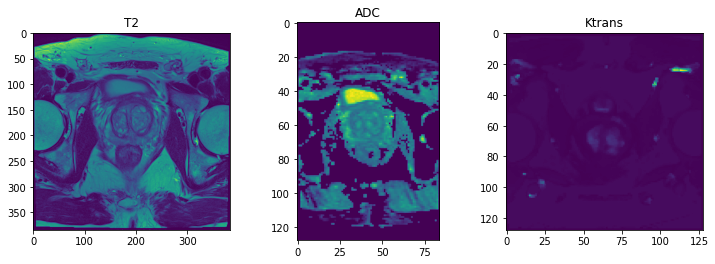

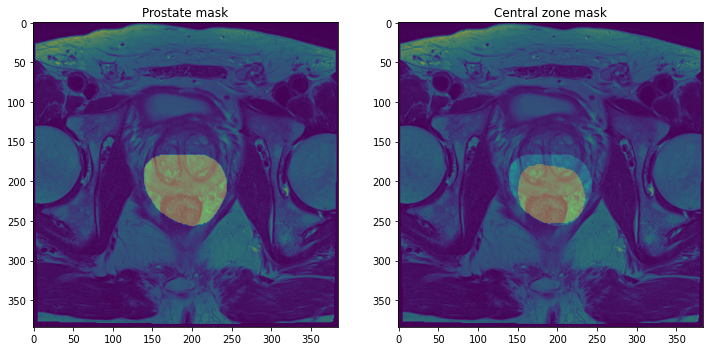

In [6]:
fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4))
ax1.imshow(ndi.rotate(t2_image[:, :, t2_image.shape[2]//2], 90))
ax1.set_title('T2');

ax2.imshow(ndi.rotate(adc_image[:, :, adc_image.shape[2]//2], 90))
ax2.set_title('ADC');

ax3.imshow(ndi.rotate(ktrans_image[:, :, ktrans_image.shape[2]//2], 90))
ax3.set_title('Ktrans');

fig2, (ax4, ax5) = plt.subplots(1, 2, figsize = (12, 6))
ax4.imshow(ndi.rotate(t2_image[:, :, t2_image.shape[2]//2], 90))
ax4.imshow(ndi.rotate(mask[:, :, mask.shape[2]//2], 90), alpha=0.35)
ax4.set_title('Prostate mask');

ax5.imshow(ndi.rotate(t2_image[:, :, t2_image.shape[2]//2], 90))
ax5.imshow(ndi.rotate(cz_mask[:, :, cz_mask.shape[2]//2], 90), alpha=0.35)
ax5.set_title('Central zone mask');

In [7]:
for c in [0,3]:
    plot_multi_mask(plotting_img[:,:,:,c], plotting_rois, title='Prostate Lesions Masks')

interactive(children=(IntSlider(value=12, description='z', max=23, style=SliderStyle(handle_color='lightblue')…

interactive(children=(IntSlider(value=12, description='z', max=23, style=SliderStyle(handle_color='lightblue')…

## Plot series 

In [9]:
def plot_nifti(example_img, masks=None, fig_rows=1, fig_cols=4):
    n_subplots = fig_rows * fig_cols
    n_slice = example_img.shape[2]
    step_size = n_slice // n_subplots
    plot_range = n_subplots * step_size
    start_stop = int((n_slice - plot_range) / 2)

    fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10])

    for idx, img in enumerate(range(start_stop, plot_range, step_size)):
        axs.flat[idx].imshow(ndi.rotate(example_img[:, :, img], 90))
        
        if masks:
            cz_mask, _ = nrrd.read(masks['cz'])
            axs.flat[idx].imshow(ndi.rotate(cz_mask[:, :, img], 90), alpha=0.3)
        
    plt.tight_layout()
    plt.show()

### T2-weighted, ADC, and KTrans series


T2-weighted series:


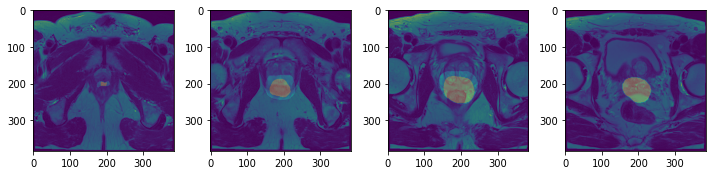


ADC series:


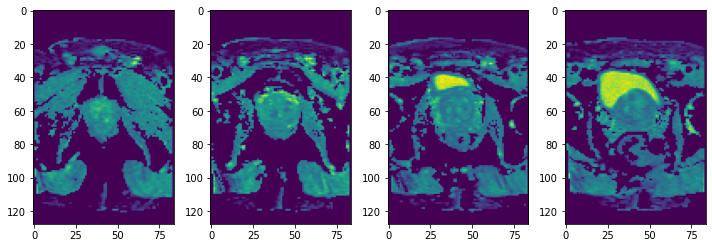


KTrans series:


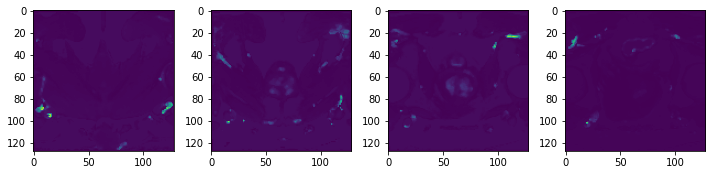

In [10]:
print(f'\nT2-weighted series:')
plot_nifti(
    t2_image, 
    masks=patients[patient_id_example]['masks']
)

print(f'\nADC series:')
plot_nifti(adc_image)

print(f'\nKTrans series:')
plot_nifti(ktrans_image)